In [1]:
import config as config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly as py #pip install plotly
import plotly.graph_objs as go
from scipy import stats
from prophet import Prophet #pip install fbprophet
import warnings


In [2]:
# load all data
energy = pd.read_csv('/Users/abhijeet/Desktop/Didi/household_power_consumption.txt',sep=';', na_values="?")

Text(0.5, 1.0, 'Single Household Energy Consumption Hourly')

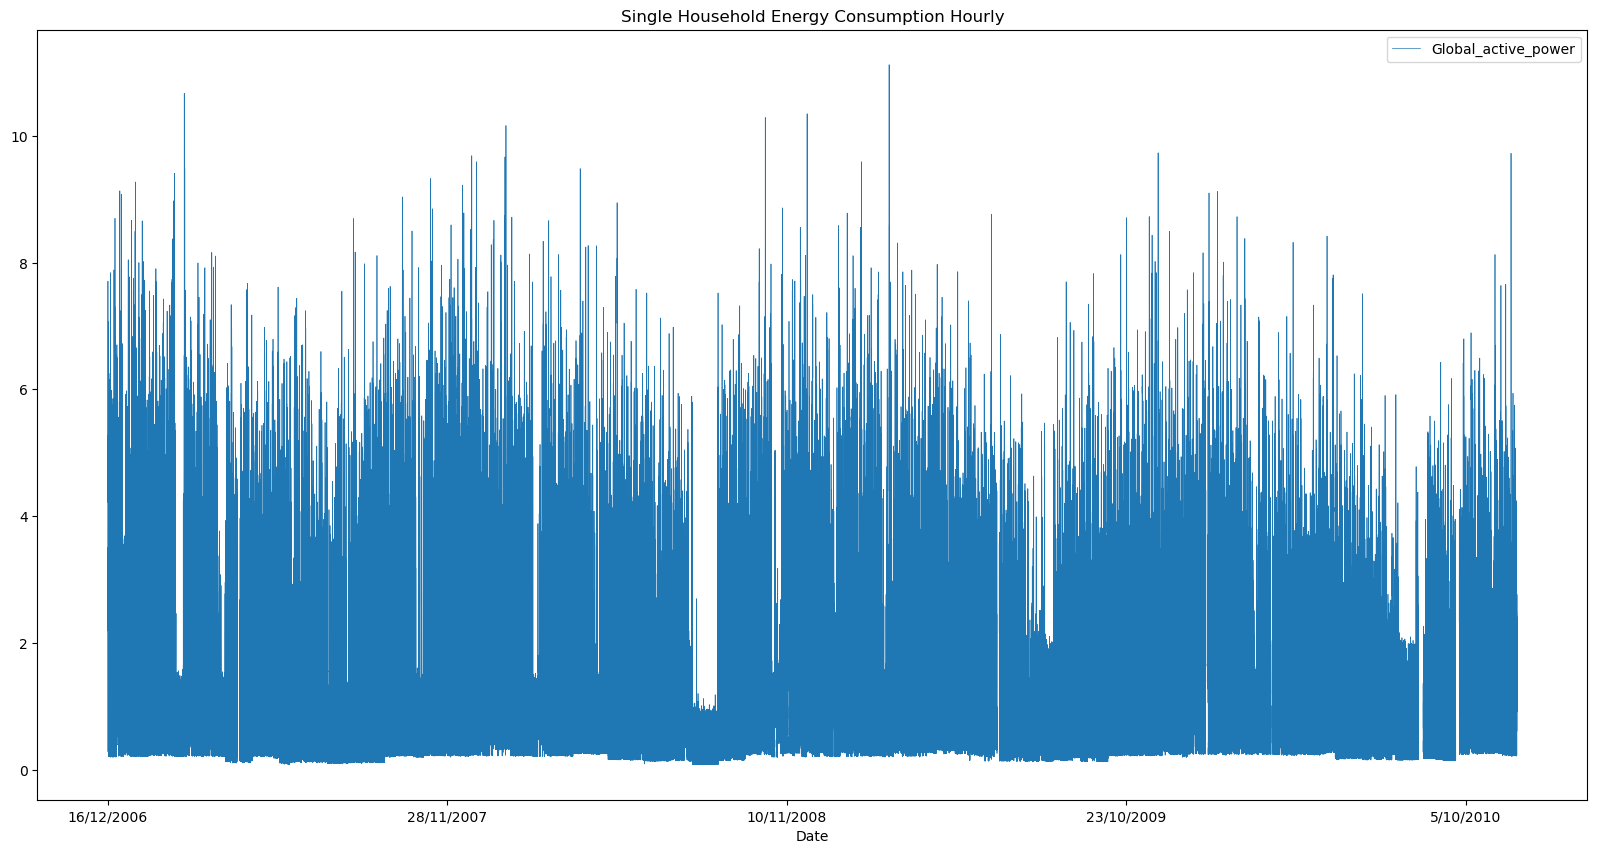

In [3]:
from matplotlib.pyplot import figure

energy.plot(x='Date',y='Global_active_power',lw = 0.5,figsize=(20,10))
plt.title("Single Household Energy Consumption Hourly")

In [4]:
energy.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [5]:
energy.head(5)

Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0

In [6]:
energy.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
dtypes = {'Date': str,
          'Time': str,
          'Global_active_power': float,
          'Global_reactive_power': float,
          'Voltage': float,
          'Global_intensity': float,
          'Sub_metering_1': float,
          'Sub_metering_2': float,
          'Sub_metering_3': float}

#Deal with missing values
energy = energy.fillna(method='ffill')

In [8]:
energy.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [9]:
#Insert additional columns
energy.insert(0, 'Date_Time', pd.to_datetime(energy['Date'] + ' ' + energy['Time'])) #datetime format
energy.insert(2, 'Year',energy['Date_Time'].dt.year) #year
energy.insert(3, 'Month',energy['Date_Time'].dt.month) #month
energy.insert(4, 'Day',energy['Date_Time'].dt.weekday) #weekday_name
energy.insert(5, 'Hour',energy['Date_Time'].dt.hour) #hour

#Exclude other numerical variables (univariate analysis)
energy = energy.iloc[:,0:8]

#Preview data
energy.head()

Date_Time        Date  Year  Month  Day  Hour      Time  \
0 2006-12-16 17:24:00  16/12/2006  2006     12    5    17  17:24:00   
1 2006-12-16 17:25:00  16/12/2006  2006     12    5    17  17:25:00   
2 2006-12-16 17:26:00  16/12/2006  2006     12    5    17  17:26:00   
3 2006-12-16 17:27:00  16/12/2006  2006     12    5    17  17:27:00   
4 2006-12-16 17:28:00  16/12/2006  2006     12    5    17  17:28:00   

   Global_active_power  
0                4.216  
1                5.360  
2                5.374  
3                5.388  
4                3.666

In [10]:
energy['Global_active_power'].describe()

count    2.075259e+06
mean     1.086168e+00
std      1.053172e+00
min      7.600000e-02
25%      3.080000e-01
50%      5.980000e-01
75%      1.524000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64

In [11]:
np.round(energy['Global_active_power'].describe(), 2).apply(lambda x: format(x, 'f'))

count    2075259.000000
mean           1.090000
std            1.050000
min            0.080000
25%            0.310000
50%            0.600000
75%            1.520000
max           11.120000
Name: Global_active_power, dtype: object

/Users/abhijeet/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/abhijeet/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/abhijeet/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an

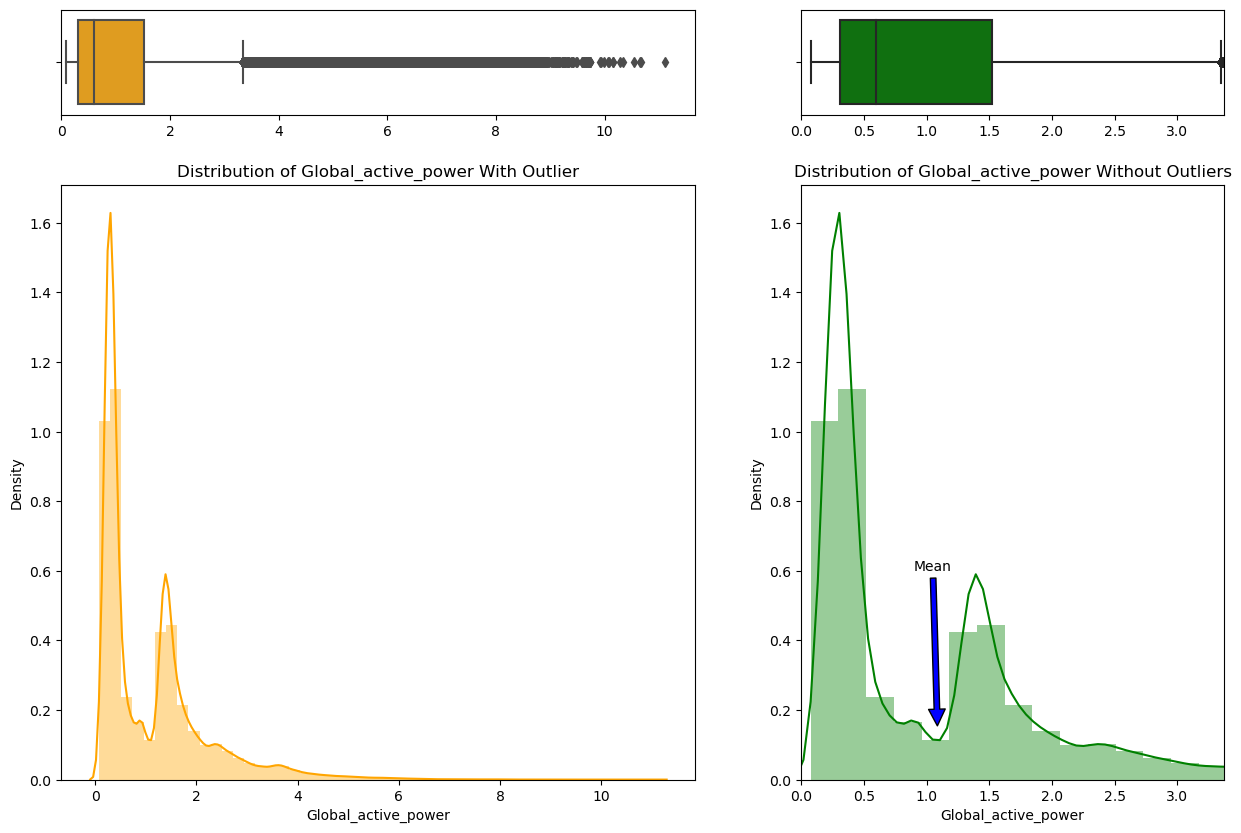

In [12]:
# Create subplots
f, axes = plt.subplots(2,
                       2, 
                       figsize=(15, 10), 
                       sharex=False, 
                       gridspec_kw={"height_ratios": (.15, .85),"width_ratios":(.60,.40)})
#Main boxplot
sns.boxplot(energy["Global_active_power"] , color="orange", ax=axes[0,0])
axes[0,0].set_xlabel('')
axes[0,0].set_xlim(0, None)

#Main distribution
sns.distplot(energy["Global_active_power"] , color="orange", ax=axes[1,0])
axes[0,0].set_xlim(0, None)
axes[1,0].set_title('Distribution of Global_active_power With Outlier')

#Zoom boxplot
sns.boxplot(energy["Global_active_power"], color="green", ax=axes[0,1])
axes[0,1].set_xlabel('')
axes[0,1].set_xlim(0, 3.37)

#Zoom distribution
sns.distplot(energy["Global_active_power"], color="green", ax=axes[1,1])
axes[1,1].set_title('Distribution of Global_active_power Without Outliers')
axes[1,1].set_xlim(0, 3.37)

# Add an arrow to mark the mean value
axes[1,1].annotate(
'Mean', xy=(energy["Global_active_power"].mean(), .15), xytext=(.9, .6),
arrowprops=dict(facecolor='blue', shrink=0.01))

plt.show()

Text(0.5, 1.0, 'Single Household Energy Consumption Hourly')

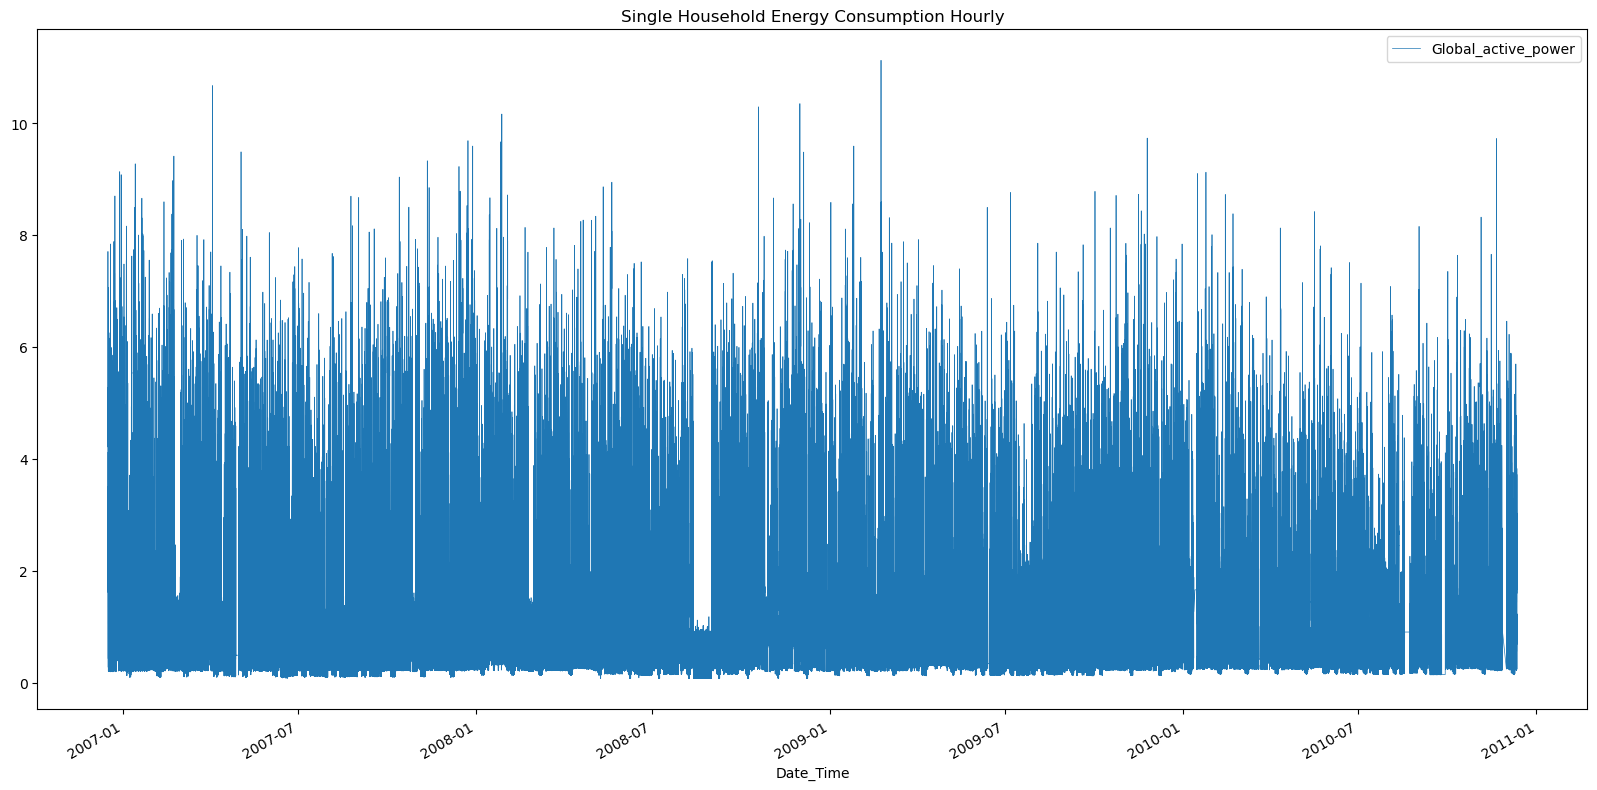

In [13]:
from matplotlib.pyplot import figure

energy.plot(x='Date_Time',y='Global_active_power',lw = 0.5,figsize=(20,10))
plt.title("Single Household Energy Consumption Hourly")

In [14]:
energy.head(5)

Date_Time        Date  Year  Month  Day  Hour      Time  \
0 2006-12-16 17:24:00  16/12/2006  2006     12    5    17  17:24:00   
1 2006-12-16 17:25:00  16/12/2006  2006     12    5    17  17:25:00   
2 2006-12-16 17:26:00  16/12/2006  2006     12    5    17  17:26:00   
3 2006-12-16 17:27:00  16/12/2006  2006     12    5    17  17:27:00   
4 2006-12-16 17:28:00  16/12/2006  2006     12    5    17  17:28:00   

   Global_active_power  
0                4.216  
1                5.360  
2                5.374  
3                5.388  
4                3.666

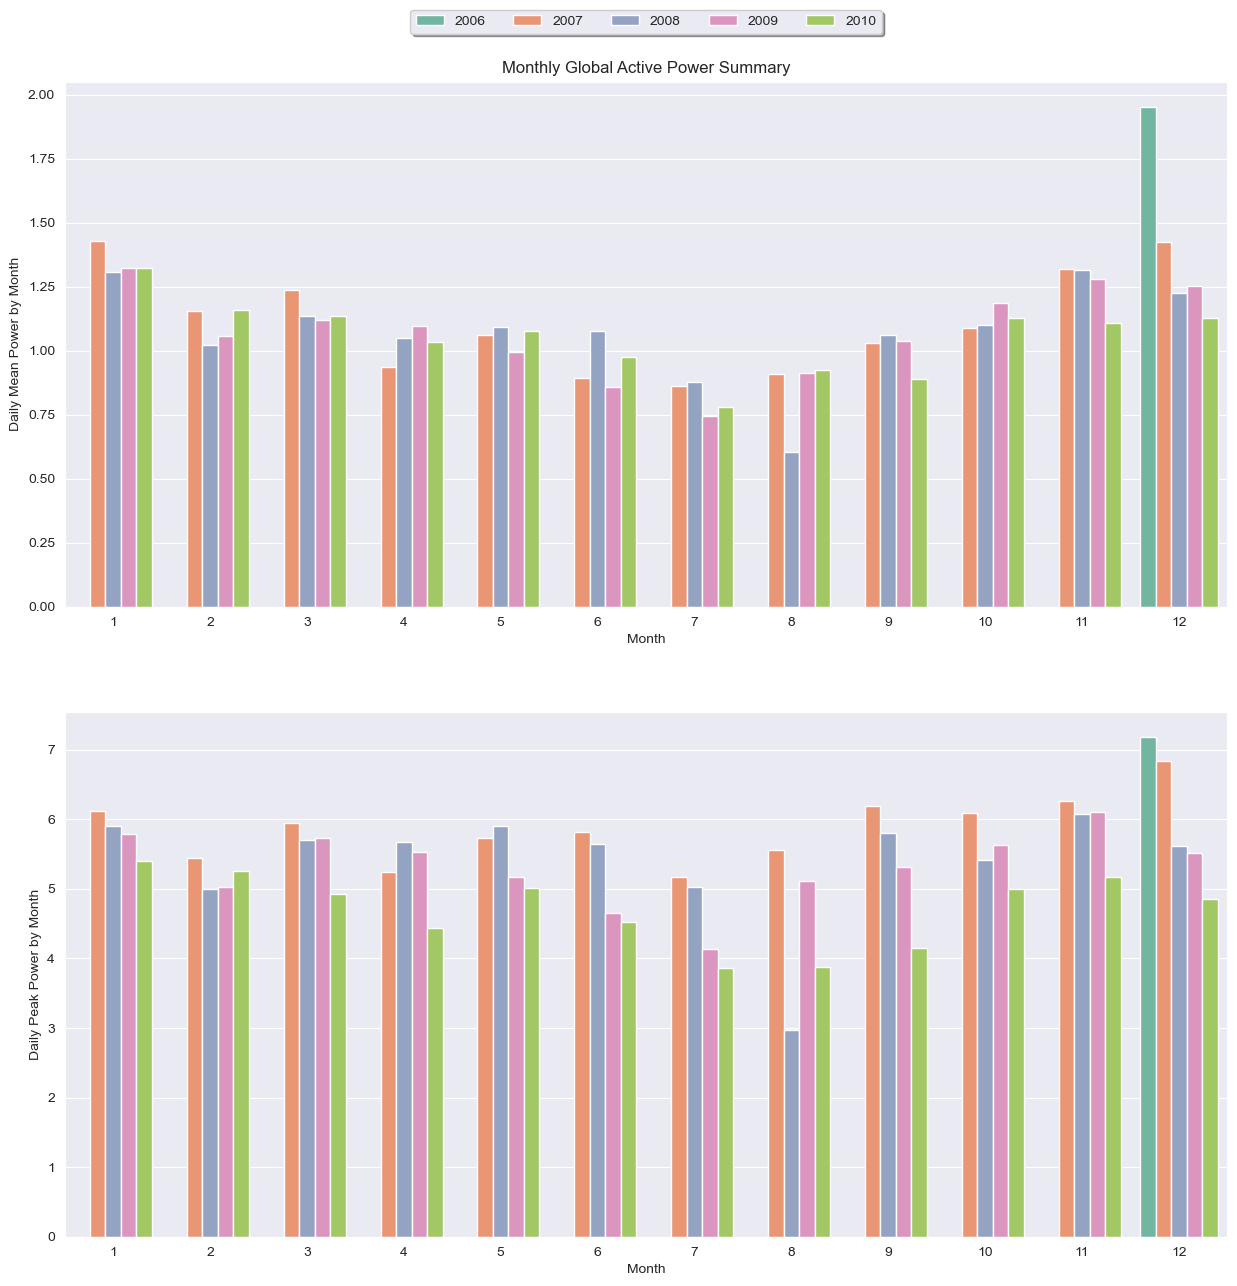

In [15]:
# Summarize power by month (mean, median, max)
energy_monthly_summary = (energy.groupby(['Year','Month','Date'],as_index=False).agg(**{'mean_active_power':('Global_active_power','mean'), \
                                                                            'median_active_power':('Global_active_power','median'), \
                                                                            'max_active_power':('Global_active_power','max')}))


# Create subplots
sns.set_style("darkgrid")
f, axes = plt.subplots(2, figsize=(15, 15), sharex=False)

# Monthly Mean subplot
mean = sns.barplot(x=energy_monthly_summary.Month,
            y=energy_monthly_summary.mean_active_power,
            hue=energy_monthly_summary.Year,
            palette="Set2",
            ax=axes[0],
            ci=None)
mean.set_title('Monthly Global Active Power Summary')
mean.set_ylabel('Daily Mean Power by Month')
mean.legend_.remove()

# Monthly Median subplot
#median = sns.barplot(x=energy_monthly_summary.Month,
#            y=energy_monthly_summary.median_active_power,
#            hue=energy_monthly_summary.Year,
#            palette="Set2",
#            ax=axes[1],
#            ci=None)
#median.legend_.remove()
#median.set_ylabel('Daily Median Power by Month')

# Monthly Peak subplot
max = sns.barplot(x=energy_monthly_summary.Month,
            y=energy_monthly_summary.max_active_power,
            hue=energy_monthly_summary.Year,
            palette="Set2",
            ax=axes[1],
            ci=None) 
max.set_ylabel('Daily Peak Power by Month')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 2.35), shadow=True, ncol=5)

In [16]:
#energy_monthly_summary

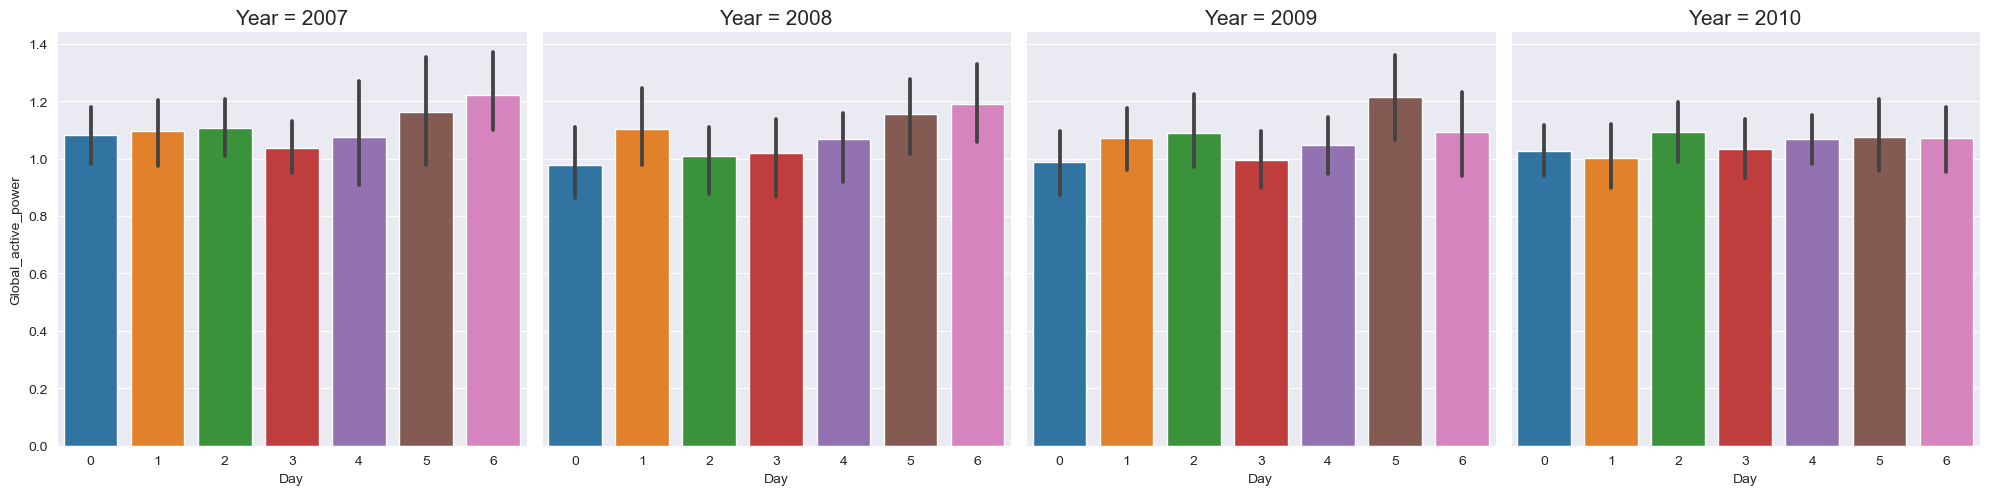

In [17]:
energy_weekday_summary = energy.groupby(by=['Year','Month','Day'], as_index=False)[['Global_active_power']].mean()

day_plot = sns.catplot(x="Day", y="Global_active_power", data=energy_weekday_summary.query("Year != 2006"), 
           kind="bar",
           col="Year")
day_plot.set_titles(size = 15)

In [18]:
from sklearn import preprocessing

#summarize by mean hourly energy
energy_hourly_summary = energy.groupby(
    by=['Year','Month','Day',"Hour"], as_index=False)[['Global_active_power']].mean()

#create the Label Encoder object
le = preprocessing.LabelEncoder()

#encode categorical data
energy_hourly_summary['Year'] = le.fit_transform(energy_hourly_summary['Year'])
energy_hourly_summary.head()

Year  Month  Day  Hour  Global_active_power
0     0     12    0     0             0.637967
1     0     12    0     1             0.760033
2     0     12    0     2             0.361233
3     0     12    0     3             0.449950
4     0     12    0     4             0.802500

In [19]:
from sklearn.model_selection import train_test_split
x = energy_hourly_summary[['Year','Month','Day','Hour']]
y = energy_hourly_summary.Global_active_power
x_train,x_test,y_train,y_test=train_test_split(x, y, train_size=0.75, test_size = 0.25, random_state=1)

## SARIMA

In [20]:
#Partioning data 
indexed_engery = energy[['Date_Time','Global_active_power', 'Year', 'Month']].set_index('Date_Time');
train = indexed_engery[indexed_engery['Year'] < 2010] #train set is years 2006 - 2009
test = indexed_engery[indexed_engery['Year'] == 2010] #test set is year 2010

In [21]:
# Define test and train data for weekly power consumption
train_monthly=train[['Global_active_power']].resample('W').mean() 
test_monthly=test[['Global_active_power']].resample('W').mean() 
print('\nShape of Train Dataset = (%s, %s)'%(train_monthly.shape))
print('\nShape of Test Dataset = (%s, %s)'%(test_monthly.shape))


Shape of Train Dataset = (160, 1)

Shape of Test Dataset = (50, 1)


In [22]:
#fitting SARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
model1 = SARIMAX(train_monthly, order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 100), #100 = number of weeks that we are forcasting
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = model1.fit()

/Users/abhijeet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [23]:
results.forecast()

2010-01-10    0.924668
Freq: W-SUN, dtype: float64

In [24]:
predictions = results.predict(start='2010-01-03', end='2010-12-19')
predictions.shape

(51,)

## Evaluation

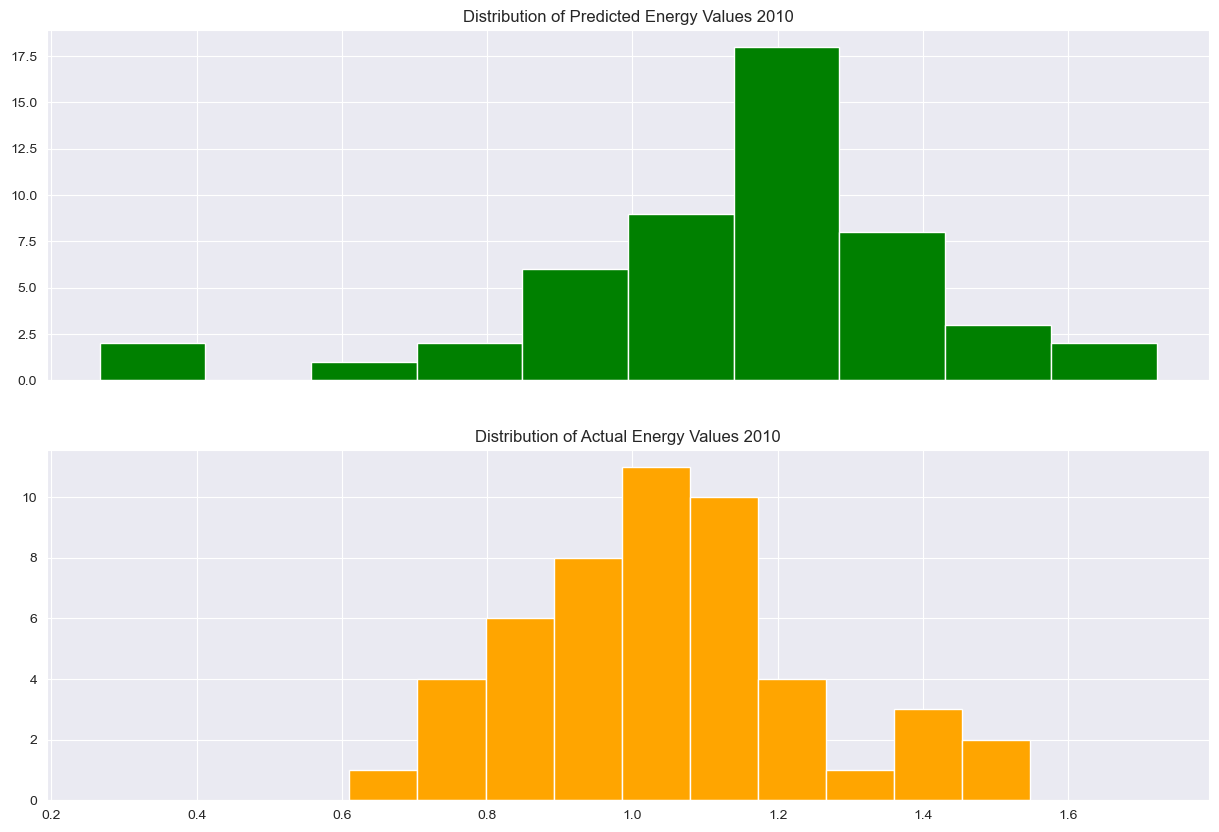

In [25]:
# predictions.index
f, axes = plt.subplots(2, figsize=(15, 10), sharex=True)
axes[0].hist(predictions.values, bins=10,color='green')
axes[0].set_title("Distribution of Predicted Energy Values 2010")
axes[1].hist((test[['Global_active_power']].resample('W').mean().values), bins=10,color='Orange')
axes[1].set_title("Distribution of Actual Energy Values 2010")
plt.show()

In [26]:
#merge on Date_Time
prediction = pd.DataFrame(predictions).reset_index()
prediction.columns = ['Date_Time','Global_active_power']

res = pd.merge(test_monthly, 
               prediction, 
               how='left', 
               on='Date_Time')

res.columns = ['Date_Time','actual','predictions']
res.insert(3, 'residuals', res['actual'] - res['predictions']) #residuals
res.head()


Date_Time    actual  predictions  residuals
0 2010-01-03  0.976101     1.285106  -0.309005
1 2010-01-10  0.920572     0.924668  -0.004096
2 2010-01-17  1.451530     1.331707   0.119823
3 2010-01-24  1.535291     1.302757   0.232535
4 2010-01-31  1.548028     0.782211   0.765818

In [27]:
#MSE
print("MSE = ", np.mean(res['residuals']**2)) #MSE
print("RMSE = ", np.sqrt(np.mean(res['residuals']**2))) #RMSE


MSE =  0.07010820324730187
RMSE =  0.26477953706300994


In [28]:
# accuracy measures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

MSE = mean_squared_error(res['actual'], res['predictions'])
MAE = mean_absolute_error(res['actual'], res['predictions'])
R2 = r2_score(res['actual'], res['predictions'])
print(f'\nMSE : {MSE}, MAE: {MAE}, R2: {R2}\n')


MSE : 0.07010820324730187, MAE: 0.19870576497389641, R2: -0.7503334120705796



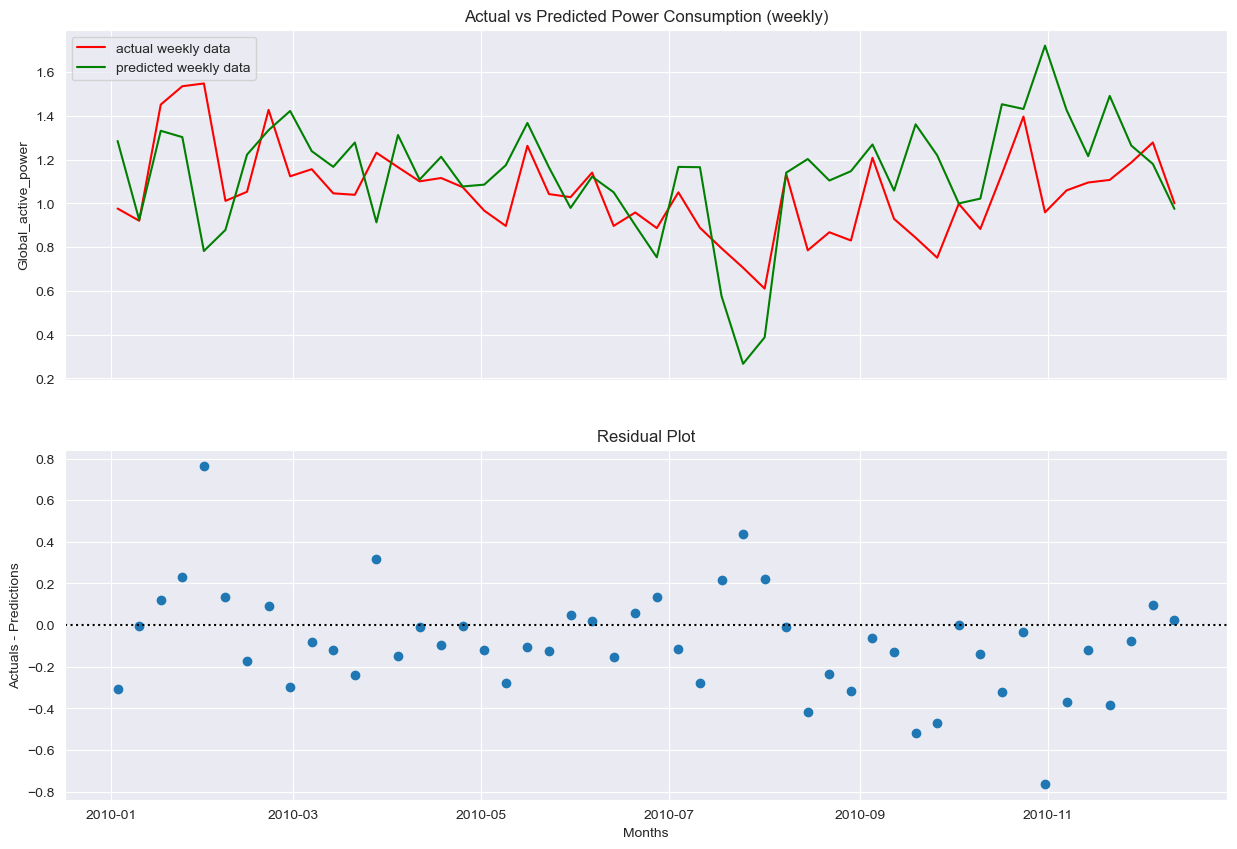

In [29]:
f, axes = plt.subplots(2, figsize=(15, 10), sharex=True)

#plot of actual vs predictions
axes[0].plot(res['Date_Time'],res['actual'], color='red', label='actual weekly data')
axes[0].plot(res['Date_Time'],res['predictions'], color='green', label='predicted weekly data')
axes[0].set_title('Actual vs Predicted Power Consumption (weekly)')
axes[0].set_ylabel('Global_active_power')
axes[0].legend()

#plot of actual - predictions
axes[1].scatter(res['Date_Time'],(res['actual'] - res['predictions']))
axes[1].set_title('Residual Plot')
axes[1].set_xlabel('Months')
axes[1].set_ylabel('Actuals - Predictions')
axes[1].axhline(y=0, color='black', linestyle=':')

plt.show()


## PROPHET

In [30]:
# Copying the same training data
train_2 = train.resample('W').mean().reset_index()
train_2 = train_2[['Date_Time', 'Global_active_power']]
train_2.columns = ['ds', 'y']
train_2.shape

(160, 2)

In [31]:
# Copying the same test data
test_2 = test.resample('W').mean().reset_index()
test_2 = test_2[['Date_Time', 'Global_active_power']]
test_2.columns = ['ds', 'y']
test_2.head()

ds         y
0 2010-01-03  0.976101
1 2010-01-10  0.920572
2 2010-01-17  1.451530
3 2010-01-24  1.535291
4 2010-01-31  1.548028

In [32]:
ph = Prophet(weekly_seasonality=False)
ph.add_seasonality(name='weekly', period=1, fourier_order=8)
ph.fit(train_2)

23:18:12 - cmdstanpy - INFO - Chain [1] start processing
23:18:12 - cmdstanpy - INFO - Chain [1] done processing


Text(0, 0.5, 'Global_active_power')

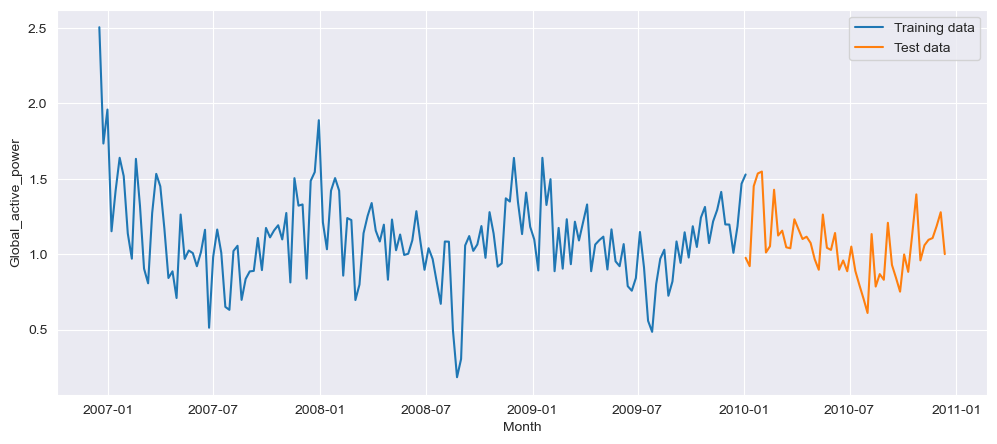

In [33]:
fig = plt.figure(figsize=(12, 5))
plt.plot(train_2['ds'], train_2['y'], label='Training data')
plt.plot(test_2['ds'], test_2['y'], label='Test data')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Global_active_power')

In [34]:
future = ph.make_future_dataframe(periods=365)
forecast = ph.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds      yhat  yhat_lower  yhat_upper
0 2006-12-17  1.514387    1.237293    1.784421
1 2006-12-24  1.553592    1.291056    1.825393
2 2006-12-31  1.540400    1.241084    1.802163
3 2007-01-07  1.468160    1.192647    1.744826
4 2007-01-14  1.388454    1.096604    1.664491

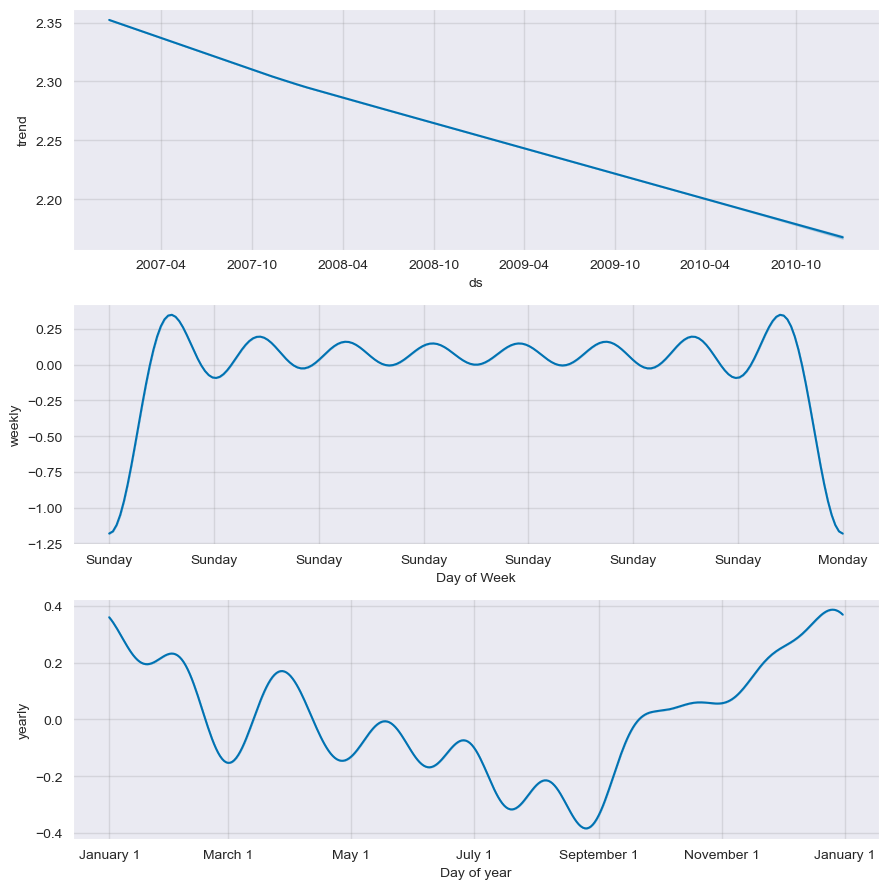

In [58]:
# plt.clf()
Prophet.plot_components(ph,forecast)
plt.savefig('./test.png')

## Evaluation

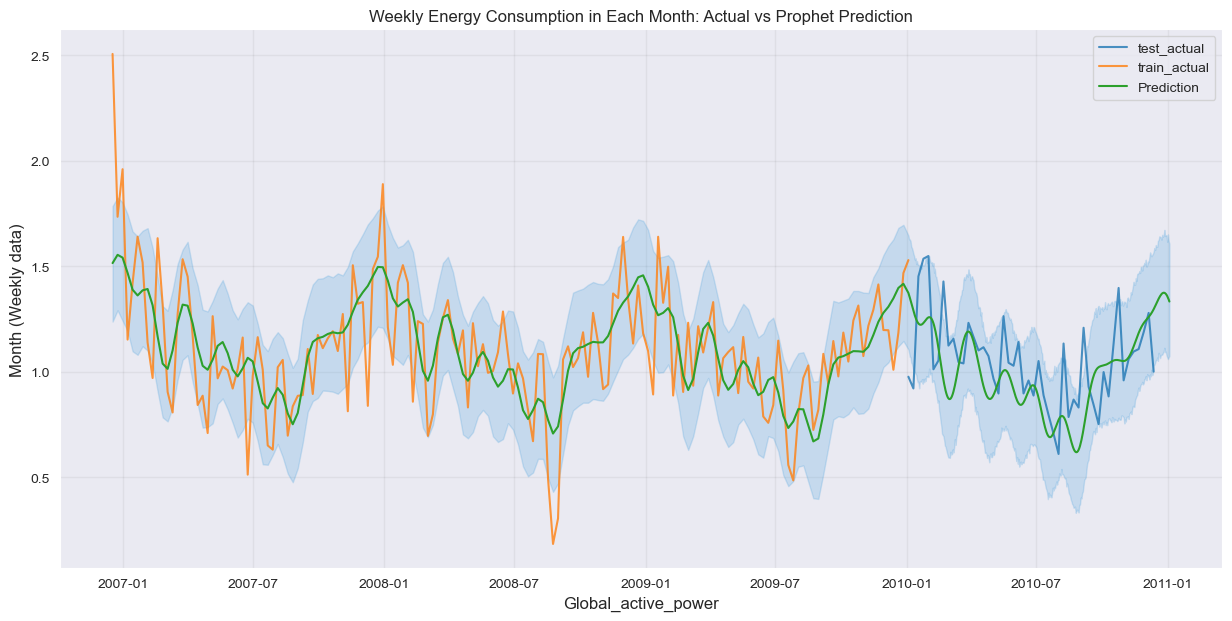

In [36]:
fig = plt.gcf()
fig.set_size_inches(15, 7)
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.plot(test_2.ds, test_2.y, '-', color='C0', label = "test_actual", alpha=0.8)
plt.plot(train_2.ds, train_2.y, '-', color='C1', label = "train_actual", alpha=0.8)
plt.plot(forecast.ds, forecast.yhat, color='C2', label = "Prediction")

plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.xlabel('Global_active_power', fontsize=12)
plt.title('Weekly Energy Consumption in Each Month: Actual vs Prophet Prediction', fontsize=12)
plt.ylabel('Month (Weekly data)', fontsize=12)
plt.legend()
plt.show()

In [37]:
# merge the predictions with actuals
merged = test_2.merge(forecast,left_on='ds', right_on='ds')

# plot the actuals versus predicted
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=merged['ds'],y=merged['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=merged['ds'],y=merged['y'], name='Actual'))
fig.update_layout(
    width=1000,
    height=400,
    title_text="Actual vs Predicted Daily Enegry Power Consumption in 2010",
    title_x = 0.44,
    xaxis_title="Month",
    yaxis_title="Power Usage(Kilowatts)",
    font=dict(
        family="Verdana, monospace",
        size=10,
        color="black"
    )
)
fig.show()

In [38]:
# accuracy measures
MSE = mean_squared_error(merged.y, merged.yhat)
MAE = mean_absolute_error(merged.y, merged.yhat)
R2 = r2_score(merged.y, merged.yhat)
print(f'MSE : {MSE}')
print(f'MAE: {MAE}')
print(f'R2: {R2}')
# merge on Date_Time
res2 = pd.merge(test_2, 
               forecast[['ds','yhat']], 
               how='left', 
               on='ds')
res2.columns = ['Date_Time','actual','predictions']
res2.insert(3, 'residuals', res2['actual'] - res2['predictions']) #residuals
res2.head()

print("RMSE = ", np.sqrt(np.mean(res2['residuals']**2))) #RMSE


MSE : 0.041341672606371595
MAE: 0.15950099503357723
R2: -0.03214328027441016
RMSE =  0.20332651722382794


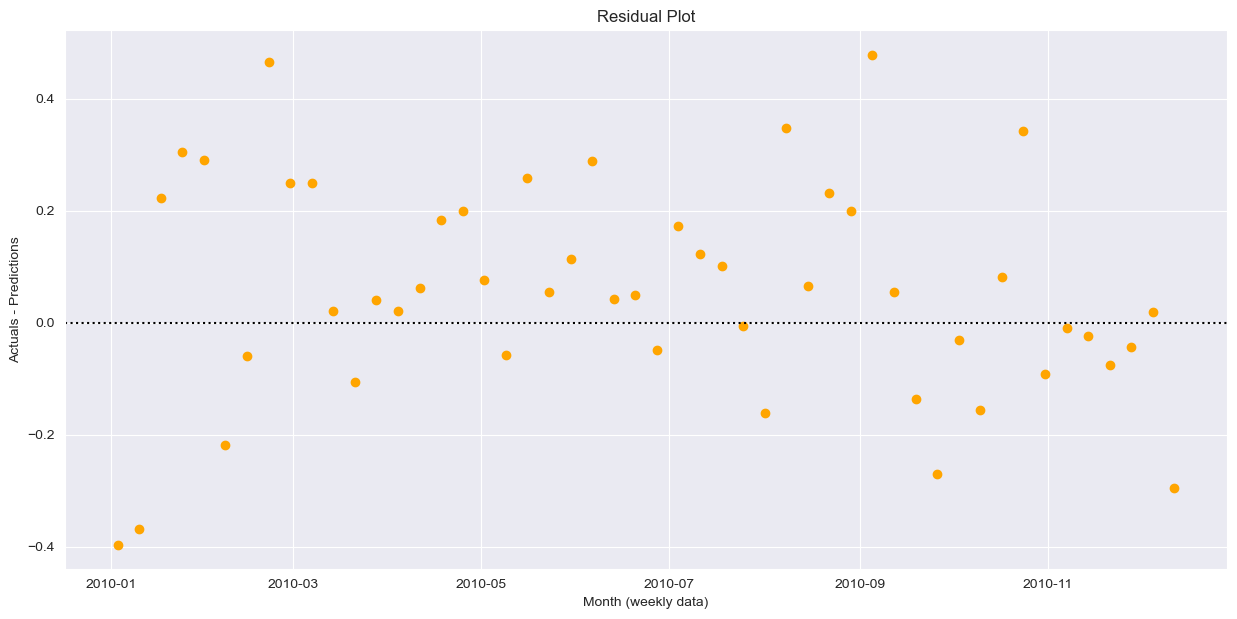

In [39]:
fig = plt.gcf()
fig.set_size_inches(15, 7)

#plot of residuals
plt.scatter(res2['Date_Time'],(res2['residuals']), color='orange')
plt.title('Residual Plot')
plt.xlabel('Month (weekly data)')
plt.ylabel('Actuals - Predictions')
plt.axhline(y=0, color='k', linestyle=':')

plt.show()

## END !